In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, matthews_corrcoef, confusion_matrix, 
                             classification_report, roc_curve, auc)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('ferroptosis_features.csv')
print(f"Shape: {df.shape}")
print(f"\nClass distribution:\n{df['Class'].value_counts()}")

Shape: (1928, 2094)

Class distribution:
Class
Ferroptosis-Inducer      971
Ferroptosis-Inhibitor    957
Name: count, dtype: int64


In [3]:
print("="*70)
print("DUPLICATE CHECK")
print("="*70)

print(f"\nOriginal shape: {df.shape}")
print(f"Total SMILES: {len(df)}")
print(f"Unique SMILES: {df['SMILES'].nunique()}")
print(f"Duplicates: {len(df) - df['SMILES'].nunique()}")

dup_smiles = df[df.duplicated(subset=['SMILES'], keep=False)]
if len(dup_smiles) > 0:
    conflicts = dup_smiles.groupby('SMILES')['Class'].nunique()
    conflicting = conflicts[conflicts > 1]
    print(f"\nSMILES with CONFLICTING labels: {len(conflicting)}")
    if len(conflicting) > 0:
        print("\nFirst 5 conflicts:")
        for smiles in conflicting.index[:5]:
            print(f"\n{smiles}")
            print(df[df['SMILES'] == smiles][['SMILES', 'Class']].to_string())

DUPLICATE CHECK

Original shape: (1928, 2094)
Total SMILES: 1928
Unique SMILES: 1624
Duplicates: 304

SMILES with CONFLICTING labels: 13

First 5 conflicts:

C(OC(C(F)(F)F)C(F)(F)F)F
                        SMILES                  Class
163   C(OC(C(F)(F)F)C(F)(F)F)F    Ferroptosis-Inducer
799   C(OC(C(F)(F)F)C(F)(F)F)F    Ferroptosis-Inducer
1402  C(OC(C(F)(F)F)C(F)(F)F)F  Ferroptosis-Inhibitor

C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O
                                                SMILES                  Class
97    C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O    Ferroptosis-Inducer
948   C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O    Ferroptosis-Inducer
1554  C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O  Ferroptosis-Inhibitor
1555  C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O  Ferroptosis-Inhibitor
1556  C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O  Ferroptosis-Inhibitor
1557  C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O  Ferroptosis-Inhibitor

C1=C

In [4]:
df = df.drop_duplicates(subset=['SMILES'], keep='first').reset_index(drop=True)

print(f"\n{'='*70}")
print("AFTER DEDUPLICATION")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nClass distribution:\n{df['Class'].value_counts()}")


AFTER DEDUPLICATION
Shape: (1624, 2094)

Class distribution:
Class
Ferroptosis-Inhibitor    813
Ferroptosis-Inducer      811
Name: count, dtype: int64


In [5]:
y = (df['Class'] == 'Ferroptosis-Inducer').astype(int).values
feature_cols = [col for col in df.columns if col not in ['SMILES', 'Class']]
X = df[feature_cols].values

print(f"X: {X.shape}, y: {y.shape}")
print(f"Inducer=1: {np.sum(y==1)}, Inhibitor=0: {np.sum(y==0)}")

X: (1624, 2092), y: (1624,)
Inducer=1: 811, Inhibitor=0: 813


In [6]:
print("CHECKING FOR BAD VALUES...")
print(f"NaN values: {np.isnan(X).sum()}")
print(f"Inf values: {np.isinf(X).sum()}")
print(f"Max value: {np.max(X[~np.isinf(X)])}")
print(f"Min value: {np.min(X[~np.isinf(X)])}")

CHECKING FOR BAD VALUES...
NaN values: 87
Inf values: 2
Max value: nan
Min value: nan


In [7]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nAfter cleaning:")
print(f"NaN values: {np.isnan(X).sum()}")
print(f"Inf values: {np.isinf(X).sum()}")


After cleaning:
NaN values: 0
Inf values: 0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train - Inducer: {np.sum(y_train==1)}, Inhibitor: {np.sum(y_train==0)}")
print(f"Test - Inducer: {np.sum(y_test==1)}, Inhibitor: {np.sum(y_test==0)}")

Train: (1299, 2092), Test: (325, 2092)
Train - Inducer: 649, Inhibitor: 650
Test - Inducer: 162, Inhibitor: 163


In [9]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, 
                            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                            random_state=42, eval_metric='logloss', n_jobs=-1)
}

trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model

Training Random Forest...
Training XGBoost...


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], n_jobs=-1)
    
    cv_results[name] = {
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1': scores['test_f1'].mean(),
        'AUC': scores['test_roc_auc'].mean(),
        'Std': scores['test_accuracy'].std()
    }

cv_df = pd.DataFrame(cv_results).T.round(4)
print("\n5-FOLD CV:")
print(cv_df.sort_values('Accuracy', ascending=False))


5-FOLD CV:
               Accuracy  Precision  Recall      F1     AUC     Std
Random Forest    0.8114     0.7989  0.8351  0.8151  0.9077  0.0273
XGBoost          0.8060     0.7984  0.8197  0.8080  0.9041  0.0201


In [11]:
test_results = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    test_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

test_df = pd.DataFrame(test_results).T.round(4)
print("\nTEST SET:")
print(test_df.sort_values('Accuracy', ascending=False))


TEST SET:
               Accuracy  Precision  Recall      F1     AUC     MCC
XGBoost          0.8215     0.8171  0.8272  0.8221  0.9140  0.6431
Random Forest    0.8154     0.8000  0.8395  0.8193  0.9132  0.6316


In [12]:
ensemble = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42, eval_metric='logloss')),
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42))
    ],
    voting='soft', weights=[2, 1], n_jobs=-1
)

ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
y_proba_ens = ensemble.predict_proba(X_test)[:, 1]

print("\nENSEMBLE:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_ens):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ens):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_ens):.4f}")
print(f"F1       : {f1_score(y_test, y_pred_ens):.4f}")
print(f"AUC      : {roc_auc_score(y_test, y_proba_ens):.4f}")
print(f"MCC      : {matthews_corrcoef(y_test, y_pred_ens):.4f}")


ENSEMBLE:
Accuracy : 0.8338
Precision: 0.8253
Recall   : 0.8457
F1       : 0.8354
AUC      : 0.9176
MCC      : 0.6679


In [13]:
print("Running 5-Fold CV for Ensemble...")

ensemble_cv = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42, eval_metric='logloss')),
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42))
    ],
    voting='soft', weights=[2, 1], n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(ensemble_cv, X_train, y_train, cv=cv, 
                       scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                       n_jobs=-1)

ensemble_cv_results = {
    'Accuracy': scores['test_accuracy'].mean(),
    'Precision': scores['test_precision'].mean(),
    'Recall': scores['test_recall'].mean(),
    'F1': scores['test_f1'].mean(),
    'AUC': scores['test_roc_auc'].mean(),
    'Std': scores['test_accuracy'].std()
}

print("\nENSEMBLE 5-FOLD CV:")
print("="*60)
for metric, value in ensemble_cv_results.items():
    if metric == 'Std':
        print(f"{metric:12s}: {value:.4f}")
    else:
        print(f"{metric:12s}: {value:.4f}")

Running 5-Fold CV for Ensemble...

ENSEMBLE 5-FOLD CV:
Accuracy    : 0.8068
Precision   : 0.8022
Recall      : 0.8166
F1          : 0.8084
AUC         : 0.9067
Std         : 0.0215


In [14]:
all_cv_results = cv_results.copy()
all_cv_results['Ensemble'] = ensemble_cv_results

all_test_results = test_results.copy()
all_test_results['Ensemble'] = {
    'Accuracy': accuracy_score(y_test, y_pred_ens),
    'Precision': precision_score(y_test, y_pred_ens),
    'Recall': recall_score(y_test, y_pred_ens),
    'F1': f1_score(y_test, y_pred_ens),
    'AUC': roc_auc_score(y_test, y_proba_ens),
    'MCC': matthews_corrcoef(y_test, y_pred_ens)
}

cv_df_full = pd.DataFrame(all_cv_results).T.round(4)
test_df_full = pd.DataFrame(all_test_results).T.round(4)

print("\n" + "="*70)
print("COMPLETE RESULTS - ALL MODELS")
print("="*70)
print("\n5-FOLD CV:")
print(cv_df_full.sort_values('Accuracy', ascending=False))
print("\nTEST SET:")
print(test_df_full.sort_values('Accuracy', ascending=False))


COMPLETE RESULTS - ALL MODELS

5-FOLD CV:
               Accuracy  Precision  Recall      F1     AUC     Std
Random Forest    0.8114     0.7989  0.8351  0.8151  0.9077  0.0273
Ensemble         0.8068     0.8022  0.8166  0.8084  0.9067  0.0215
XGBoost          0.8060     0.7984  0.8197  0.8080  0.9041  0.0201

TEST SET:
               Accuracy  Precision  Recall      F1     AUC     MCC
Ensemble         0.8338     0.8253  0.8457  0.8354  0.9176  0.6679
XGBoost          0.8215     0.8171  0.8272  0.8221  0.9140  0.6431
Random Forest    0.8154     0.8000  0.8395  0.8193  0.9132  0.6316


In [15]:
print("\n" + "="*70)
print("FINAL SUMMARY - CV vs TEST")
print("="*70)
for name in ['Random Forest', 'XGBoost', 'Ensemble']:
    cv_acc = all_cv_results[name]['Accuracy']
    cv_std = all_cv_results[name]['Std']
    test_acc = all_test_results[name]['Accuracy']
    gap = abs(cv_acc - test_acc)
    
    print(f"{name:20s} CV: {cv_acc:.4f}±{cv_std:.4f}  Test: {test_acc:.4f}  Gap: {gap:.4f}")


FINAL SUMMARY - CV vs TEST
Random Forest        CV: 0.8114±0.0273  Test: 0.8154  Gap: 0.0040
XGBoost              CV: 0.8060±0.0201  Test: 0.8215  Gap: 0.0156
Ensemble             CV: 0.8068±0.0215  Test: 0.8338  Gap: 0.0271


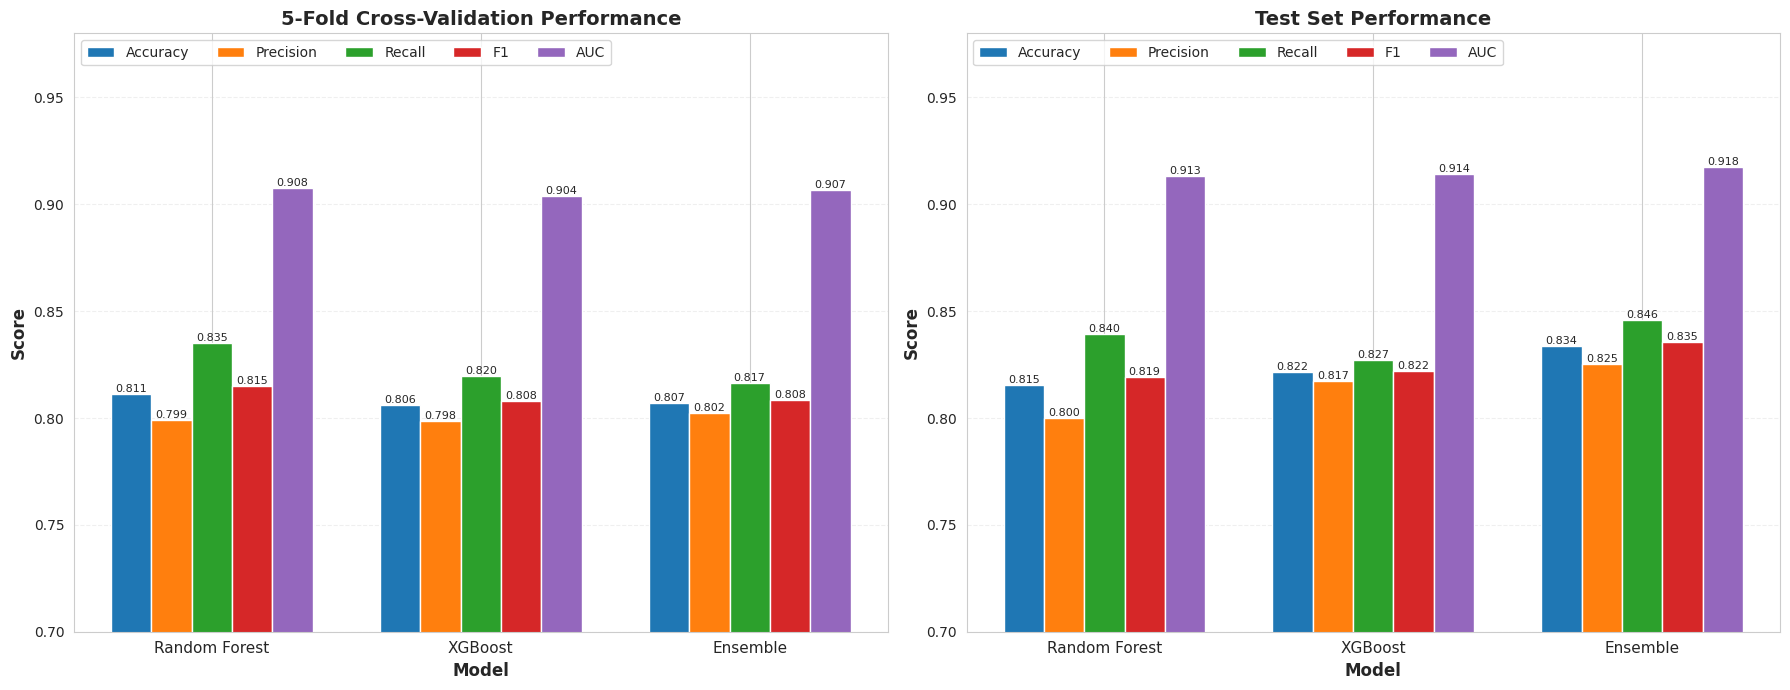

✓ Saved: model_performance_comparison.png (with values on bars)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
models_order = ['Random Forest', 'XGBoost', 'Ensemble']

cv_data = cv_df_full.loc[models_order, metrics]
x = np.arange(len(models_order))
width = 0.15

for i, metric in enumerate(metrics):
    offset = (i - 2) * width
    bars = axes[0].bar(x + offset, cv_data[metric], width, label=metric)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8, rotation=0)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('5-Fold Cross-Validation Performance', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_order, fontsize=11)
axes[0].set_ylim([0.70, 0.98])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10, ncol=5)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

test_data = test_df_full.loc[models_order, metrics]

for i, metric in enumerate(metrics):
    offset = (i - 2) * width
    bars = axes[1].bar(x + offset, test_data[metric], width, label=metric)
    
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8, rotation=0)

axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set Performance', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_order, fontsize=11)
axes[1].set_ylim([0.70, 0.98])
axes[1].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10, ncol=5)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: model_performance_comparison.png (with values on bars)")

In [17]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import numpy as np

def bm_scaffold(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=m, includeChirality=False)

scaffolds = df["SMILES"].apply(bm_scaffold)
df_scaf = df.copy()
df_scaf["scaffold"] = scaffolds
df_scaf = df_scaf.dropna(subset=["scaffold"]).reset_index(drop=True)

In [18]:
rng = np.random.RandomState(42)

scaf_to_idx = defaultdict(list)
for i, scaf in enumerate(df_scaf["scaffold"].values):
    scaf_to_idx[scaf].append(i)

all_scafs = list(scaf_to_idx.keys())
rng.shuffle(all_scafs)

n_total = len(df_scaf)
target_test = int(0.2 * n_total)

test_idx = []
train_idx = []

count_test = 0
for scaf in all_scafs:
    idxs = scaf_to_idx[scaf]
    if count_test < target_test:
        test_idx.extend(idxs)
        count_test += len(idxs)
    else:
        train_idx.extend(idxs)

train_idx = np.array(train_idx, dtype=int)
test_idx = np.array(test_idx, dtype=int)

print("Scaffold split sizes:", len(train_idx), len(test_idx))
print("Train scaffolds:", df_scaf.loc[train_idx, "scaffold"].nunique(),
      "Test scaffolds:", df_scaf.loc[test_idx, "scaffold"].nunique())

Scaffold split sizes: 1299 325
Train scaffolds: 601 Test scaffolds: 165


In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


X_clean = np.asarray(X, dtype=np.float32)
X_clean = np.nan_to_num(X_clean, nan=0.0, posinf=0.0, neginf=0.0)

y_clean = np.asarray(y, dtype=int)

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict

def bm_scaffold(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=m, includeChirality=False)

scaffolds = df["SMILES"].apply(bm_scaffold)  
valid_mask = scaffolds.notna().to_numpy()

X2 = X_clean[valid_mask]
y2 = y_clean[valid_mask]
scaff2 = scaffolds[valid_mask].to_numpy()

print("Scaffold-eval matrix:", X2.shape, "labels:", y2.shape, "unique scaffolds:", len(set(scaff2)))

scaf_to_idx = defaultdict(list)
for i, scaf in enumerate(scaff2):
    scaf_to_idx[scaf].append(i)

rng = np.random.RandomState(42)
all_scafs = list(scaf_to_idx.keys())
rng.shuffle(all_scafs)

n_total = len(y2)
target_test = int(0.2 * n_total)

test_idx = []
train_idx = []
count_test = 0
for scaf in all_scafs:
    idxs = scaf_to_idx[scaf]
    if count_test < target_test:
        test_idx.extend(idxs)
        count_test += len(idxs)
    else:
        train_idx.extend(idxs)

train_idx = np.array(train_idx, dtype=int)
test_idx = np.array(test_idx, dtype=int)

X_train_sc, X_test_sc = X2[train_idx], X2[test_idx]
y_train_sc, y_test_sc = y2[train_idx], y2[test_idx]

print("Scaffold split sizes:", X_train_sc.shape, X_test_sc.shape)
print("Train scaffolds:", len(set(scaff2[train_idx])), "Test scaffolds:", len(set(scaff2[test_idx])))

rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric="logloss", n_jobs=-1
)

rf.fit(X_train_sc, y_train_sc)
xgb.fit(X_train_sc, y_train_sc)

ens = VotingClassifier(
    estimators=[("xgb", xgb), ("rf", rf)],
    voting="soft",
    weights=[2, 1],
    n_jobs=-1
)
ens.fit(X_train_sc, y_train_sc)

def eval_model(name, model, Xte, yte):
    ypred = model.predict(Xte)
    yproba = model.predict_proba(Xte)[:, 1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(yte, ypred),
        "Precision": precision_score(yte, ypred),
        "Recall": recall_score(yte, ypred),
        "F1": f1_score(yte, ypred),
        "AUC": roc_auc_score(yte, yproba),
        "MCC": matthews_corrcoef(yte, ypred),
        "N_test": len(yte)
    }

scaffold_test_df = pd.DataFrame([
    eval_model("Random Forest (scaffold split)", rf, X_test_sc, y_test_sc),
    eval_model("XGBoost (scaffold split)", xgb, X_test_sc, y_test_sc),
    eval_model("Ensemble (scaffold split)", ens, X_test_sc, y_test_sc),
]).set_index("Model").round(4)

print("SCAFFOLD SPLIT TEST RESULTS")
display(scaffold_test_df)

Scaffold-eval matrix: (1624, 2092) labels: (1624,) unique scaffolds: 766
Scaffold split sizes: (1299, 2092) (325, 2092)
Train scaffolds: 601 Test scaffolds: 165
SCAFFOLD SPLIT TEST RESULTS


,Accuracy,Precision,Recall,F1,AUC,MCC,N_test
Model,,,,,,,
Random Forest (scaffold split),0.8431,0.7832,0.8485,0.8145,0.9202,0.6806,325
XGBoost (scaffold split),0.8308,0.7810,0.8106,0.7955,0.9266,0.6516,325
Ensemble (scaffold split),0.8277,0.7879,0.7879,0.7879,0.9272,0.6428,325


In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

rng = np.random.RandomState(42)
y_perm = rng.permutation(y_train)   

perm_rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)
perm_xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric="logloss", n_jobs=-1
)

perm_ensemble = VotingClassifier(
    estimators=[("xgb", perm_xgb), ("rf", perm_rf)],
    voting="soft",
    weights=[2, 1],
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

perm_auc = cross_val_score(
    perm_ensemble, X_train, y_perm,
    cv=cv, scoring="roc_auc", n_jobs=-1
)

print("Permutation test AUC (should be ~0.5):",
      perm_auc.mean().round(4), "+/-", perm_auc.std().round(4))

Permutation test AUC (should be ~0.5): 0.4952 +/- 0.0215


In [21]:
means = []
for i in range(20):
    y_perm = rng.permutation(y_train)
    scores = cross_val_score(perm_ensemble, X_train, y_perm, cv=cv, scoring="roc_auc", n_jobs=-1)
    means.append(scores.mean())

means = np.array(means)
print("Permutation AUC mean over 20 runs:", means.mean().round(4),
      "min:", means.min().round(4), "max:", means.max().round(4))

Permutation AUC mean over 20 runs: 0.4978 min: 0.4589 max: 0.5384


In [22]:
scaffold_test_df.to_csv("saved_models/scaffold_test_results.csv")
print("Saved: saved_models/scaffold_test_results.csv")

Saved: saved_models/scaffold_test_results.csv


In [23]:
ens_scaf = scaffold_test_df.loc[["Ensemble (scaffold split)"]]
ens_scaf.to_csv("saved_models/ensemble_scaffold_test.csv")

In [24]:
import pandas as pd
import numpy as np

perm_df = pd.DataFrame({
    "perm_id": np.arange(1, len(means) + 1),
    "auc": means
})
perm_df.to_csv("saved_models/permutation_auc_20runs.csv", index=False)
print("Saved: saved_models/permutation_auc_20runs.csv")

Saved: saved_models/permutation_auc_20runs.csv


In [25]:
perm_df = pd.DataFrame({"perm_id": np.arange(1, len(means)+1), "auc": means})
perm_df.to_csv("saved_models/ensemble_permutation_auc_20runs.csv", index=False)

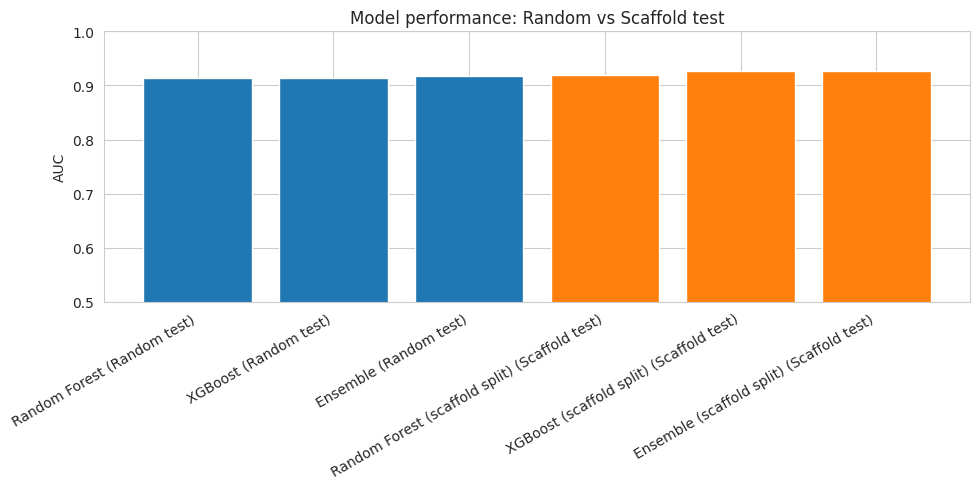

Saved: saved_models/auc_random_vs_scaffold.png


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# testdffull exists in your notebook; scaffold_test_df from new section
rand = test_df_full.copy()
scaf = scaffold_test_df.copy()

# Keep only common metrics
metrics = ["AUC", "MCC", "F1", "Accuracy"]
rand = rand[metrics].reset_index().rename(columns={"index":"Model"})
scaf = scaf[metrics].reset_index().rename(columns={"Model":"Model"})

rand["Split"] = "Random test"
scaf["Split"] = "Scaffold test"

plot_df = pd.concat([rand, scaf], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))
# plot AUC only (cleanest figure)
for split, d in plot_df.groupby("Split"):
    ax.bar(d["Model"] + " (" + split + ")", d["AUC"])

ax.set_ylabel("AUC")
ax.set_title("Model performance: Random vs Scaffold test")
ax.set_ylim(0.5, 1.0)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("saved_models/auc_random_vs_scaffold.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: saved_models/auc_random_vs_scaffold.png")


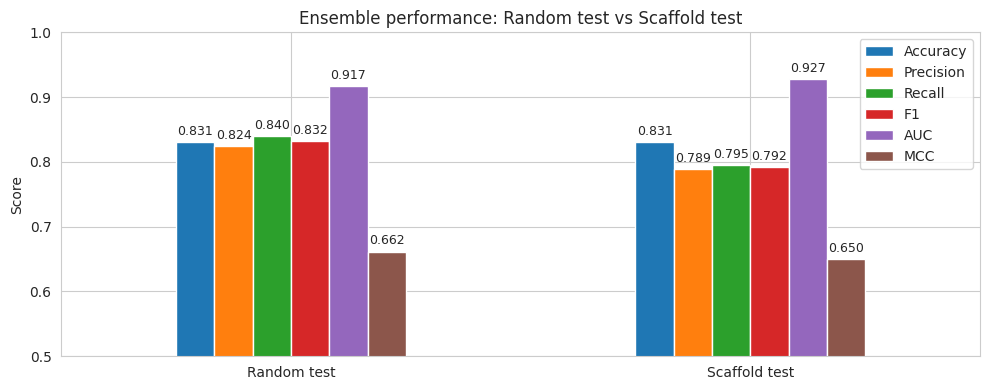

Saved: saved_models/ensemble_random_vs_scaffold_allmetrics.png


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

rand = pd.read_csv("saved_models/test_results.csv", index_col=0)
scaf = pd.read_csv("saved_models/ensemble_scaffold_test.csv", index_col=0)

metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC", "MCC"]

rand_ens = rand.loc["Ensemble", metrics].astype(float)
scaf_ens = scaf.iloc[0][metrics].astype(float)

plot_df = pd.DataFrame(
    {"Random test": rand_ens, "Scaffold test": scaf_ens},
    index=metrics
)

# Plot
ax = plot_df.T.plot(kind="bar", figsize=(10, 4))
ax.set_ylim(0.5, 1.0)
ax.set_title("Ensemble performance: Random test vs Scaffold test")
ax.set_ylabel("Score")

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("saved_models/ensemble_random_vs_scaffold_allmetrics.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: saved_models/ensemble_random_vs_scaffold_allmetrics.png")

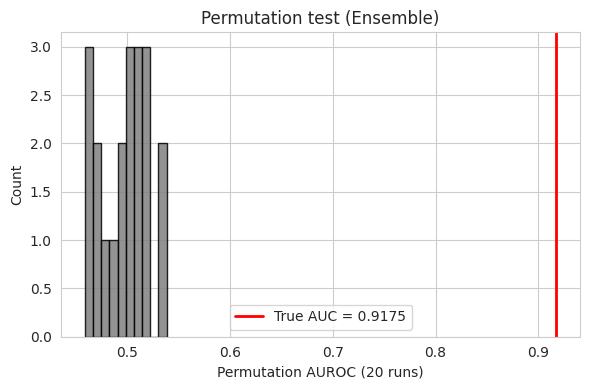

Saved: saved_models/ensemble_permutation_hist.png


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

perm = pd.read_csv("saved_models/ensemble_permutation_auc_20runs.csv")
true_auc = 0.9175 

plt.figure(figsize=(6,4))
plt.hist(perm["auc"], bins=10, color="gray", edgecolor="black", alpha=0.85)
plt.axvline(true_auc, color="red", linewidth=2, label=f"True AUC = {true_auc:.4f}")
plt.xlabel("Permutation AUROC (20 runs)")
plt.ylabel("Count")
plt.title("Permutation test (Ensemble)")
plt.legend()
plt.tight_layout()
plt.savefig("saved_models/ensemble_permutation_hist.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: saved_models/ensemble_permutation_hist.png")

In [28]:
import pickle

with open('saved_models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(trained_models['Random Forest'], f)
print("✓ Saved: saved_models/random_forest_model.pkl")

with open('saved_models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(trained_models['XGBoost'], f)
print("✓ Saved: saved_models/xgboost_model.pkl")

with open('saved_models/ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)
print("✓ Saved: saved_models/ensemble_model.pkl")

✓ Saved: saved_models/random_forest_model.pkl
✓ Saved: saved_models/xgboost_model.pkl
✓ Saved: saved_models/ensemble_model.pkl


In [29]:
import json

feature_info = {
    'feature_columns': feature_cols,
    'n_features': len(feature_cols),
    'target_encoding': {
        'Ferroptosis-Inhibitor': 0,
        'Ferroptosis-Inducer': 1
    }
}

with open('saved_models/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("✓ Saved: saved_models/feature_info.json")

✓ Saved: saved_models/feature_info.json


In [30]:
cv_df_full.to_csv('saved_models/cv_results.csv')
print("✓ Saved: saved_models/cv_results.csv")

# Save test results
test_df_full.to_csv('saved_models/test_results.csv')
print("✓ Saved: saved_models/test_results.csv")

✓ Saved: saved_models/cv_results.csv
✓ Saved: saved_models/test_results.csv


In [31]:
with open('saved_models/model_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("FERROPTOSIS QSAR MODEL - FINAL SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Dataset: {len(df)} compounds (after deduplication)\n")
    f.write(f"  Ferroptosis-Inducer:  {np.sum(y==1)}\n")
    f.write(f"  Ferroptosis-Inhibitor: {np.sum(y==0)}\n\n")
    f.write(f"Features: {X.shape[1]}\n")
    f.write(f"  Molecular Descriptors: {len([c for c in feature_cols if not c.startswith('MORGAN')])}\n")
    f.write(f"  Morgan Fingerprints: {len([c for c in feature_cols if c.startswith('MORGAN')])}\n\n")
    f.write(f"Training set: {len(X_train)} compounds\n")
    f.write(f"Test set: {len(X_test)} compounds (20% split)\n\n")
    
    f.write("="*70 + "\n")
    f.write("CROSS-VALIDATION RESULTS (5-Fold Stratified)\n")
    f.write("="*70 + "\n\n")
    f.write(cv_df_full.to_string())
    
    f.write("\n\n" + "="*70 + "\n")
    f.write("TEST SET RESULTS\n")
    f.write("="*70 + "\n\n")
    f.write(test_df_full.to_string())
    
    f.write("\n\n" + "="*70 + "\n")
    f.write("FINAL RECOMMENDATION\n")
    f.write("="*70 + "\n\n")
    f.write("Best Model: Ensemble (XGBoost + Random Forest, Soft Voting)\n")
    f.write(f"  Weights: XGBoost=2, Random Forest=1\n\n")
    f.write("Performance:\n")
    f.write(f"  CV Accuracy:   {all_cv_results['Ensemble']['Accuracy']:.4f} ± {all_cv_results['Ensemble']['Std']:.4f}\n")
    f.write(f"  Test Accuracy: {all_test_results['Ensemble']['Accuracy']:.4f}\n")
    f.write(f"  Test AUC-ROC:  {all_test_results['Ensemble']['AUC']:.4f}\n")
    f.write(f"  Test MCC:      {all_test_results['Ensemble']['MCC']:.4f}\n")
    f.write(f"  Test F1-Score: {all_test_results['Ensemble']['F1']:.4f}\n\n")
    f.write("Overfitting Check:\n")
    f.write(f"  CV-Test Gap: {abs(all_cv_results['Ensemble']['Accuracy'] - all_test_results['Ensemble']['Accuracy']):.4f}\n")
    f.write("  Status: Minimal overfitting ✓\n")

print("✓ Saved: saved_models/model_summary.txt")

✓ Saved: saved_models/model_summary.txt


In [32]:
top_n = 20

xgb_importance = trained_models['XGBoost'].feature_importances_
xgb_top_idx = np.argsort(xgb_importance)[-top_n:]
xgb_top_features = [(feature_cols[i], xgb_importance[i]) for i in xgb_top_idx]

rf_importance = trained_models['Random Forest'].feature_importances_
rf_top_idx = np.argsort(rf_importance)[-top_n:]
rf_top_features = [(feature_cols[i], rf_importance[i]) for i in rf_top_idx]

print("="*70)
print("TOP 20 FEATURES - XGBoost")
print("="*70)
for rank, (feat, imp) in enumerate(reversed(xgb_top_features), 1):
    print(f"{rank:2d}. {feat:30s} {imp:.4f}")

print("\n" + "="*70)
print("TOP 20 FEATURES - Random Forest")
print("="*70)
for rank, (feat, imp) in enumerate(reversed(rf_top_features), 1):
    print(f"{rank:2d}. {feat:30s} {imp:.4f}")

TOP 20 FEATURES - XGBoost
 1. MORGAN_bit_198                 0.0469
 2. MORGAN_bit_1683                0.0222
 3. MORGAN_bit_1040                0.0169
 4. MORGAN_bit_694                 0.0161
 5. NumRadicalElectrons            0.0160
 6. MORGAN_bit_1854                0.0142
 7. MORGAN_bit_1440                0.0132
 8. NumAromaticCarbocycles         0.0129
 9. MORGAN_bit_949                 0.0128
10. MORGAN_bit_249                 0.0124
11. MORGAN_bit_392                 0.0115
12. MORGAN_bit_1542                0.0113
13. MORGAN_bit_1109                0.0097
14. MORGAN_bit_1624                0.0094
15. HBD                            0.0087
16. MORGAN_bit_1114                0.0085
17. MORGAN_bit_314                 0.0084
18. MORGAN_bit_202                 0.0083
19. MORGAN_bit_1266                0.0076
20. MORGAN_bit_760                 0.0074

TOP 20 FEATURES - Random Forest
 1. EState_VSA2                    0.0194
 2. MaxPartialCharge               0.0171
 3. VSA_EState2  

In [33]:
ensemble_xgb = ensemble.named_estimators_['xgb']
ensemble_rf = ensemble.named_estimators_['rf']

ensemble_xgb_imp = ensemble_xgb.feature_importances_
ensemble_rf_imp = ensemble_rf.feature_importances_

ensemble_importance = (2 * ensemble_xgb_imp + 1 * ensemble_rf_imp) / 3

ensemble_top_idx = np.argsort(ensemble_importance)[-20:]
ensemble_top_features = [(feature_cols[i], ensemble_importance[i]) for i in ensemble_top_idx]

print("="*70)
print("TOP 20 FEATURES - ENSEMBLE (Weighted: XGB=2, RF=1)")
print("="*70)
for rank, (feat, imp) in enumerate(reversed(ensemble_top_features), 1):
    print(f"{rank:2d}. {feat:30s} {imp:.4f}")

TOP 20 FEATURES - ENSEMBLE (Weighted: XGB=2, RF=1)
 1. MORGAN_bit_198                 0.0338
 2. MORGAN_bit_1683                0.0158
 3. MORGAN_bit_249                 0.0128
 4. HBD                            0.0111
 5. NumAromaticCarbocycles         0.0110
 6. EState_VSA2                    0.0107
 7. MORGAN_bit_949                 0.0106
 8. NumRadicalElectrons            0.0106
 9. MORGAN_bit_1854                0.0099
10. MORGAN_bit_1440                0.0097
11. VSA_EState2                    0.0095
12. LabuteASA                      0.0090
13. MORGAN_bit_1040                0.0088
14. MinPartialCharge               0.0088
15. MORGAN_bit_694                 0.0083
16. MORGAN_bit_1109                0.0083
17. MaxPartialCharge               0.0082
18. SMR_VSA1                       0.0081
19. MORGAN_bit_1114                0.0079
20. BalabanJ                       0.0078


In [34]:
top_30_idx = np.argsort(ensemble_importance)[-30:][::-1] 

comparison_df = pd.DataFrame({
    'Feature': [feature_cols[i] for i in top_30_idx],
    'Ensemble': ensemble_importance[top_30_idx],
    'XGBoost': xgb_importance[top_30_idx],
    'RandomForest': rf_importance[top_30_idx]
})

comparison_df = comparison_df.round(4)

print("\n" + "="*70)
print("TOP 30 FEATURES - ALL MODELS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

comparison_df.to_csv('feature_importance_comparison.csv', index=False)
print("\n✓ Saved: feature_importance_comparison.csv")


TOP 30 FEATURES - ALL MODELS COMPARISON
               Feature  Ensemble  XGBoost  RandomForest
        MORGAN_bit_198    0.0338   0.0469        0.0058
       MORGAN_bit_1683    0.0158   0.0222        0.0060
        MORGAN_bit_249    0.0128   0.0124        0.0013
                   HBD    0.0111   0.0087        0.0155
NumAromaticCarbocycles    0.0110   0.0129        0.0078
           EState_VSA2    0.0107   0.0065        0.0194
        MORGAN_bit_949    0.0106   0.0128        0.0058
   NumRadicalElectrons    0.0106   0.0160        0.0016
       MORGAN_bit_1854    0.0099   0.0142        0.0011
       MORGAN_bit_1440    0.0097   0.0132        0.0007
           VSA_EState2    0.0095   0.0058        0.0166
             LabuteASA    0.0090   0.0022        0.0094
       MORGAN_bit_1040    0.0088   0.0169        0.0012
      MinPartialCharge    0.0088   0.0057        0.0144
        MORGAN_bit_694    0.0083   0.0161        0.0013
       MORGAN_bit_1109    0.0083   0.0097        0.0058
      M

Total features: 2092
Max importance: 0.0338 (3.38%)
Top 10 cumulative: 0.1360 (13.60%)
Top 50 cumulative: 0.3950 (39.50%)


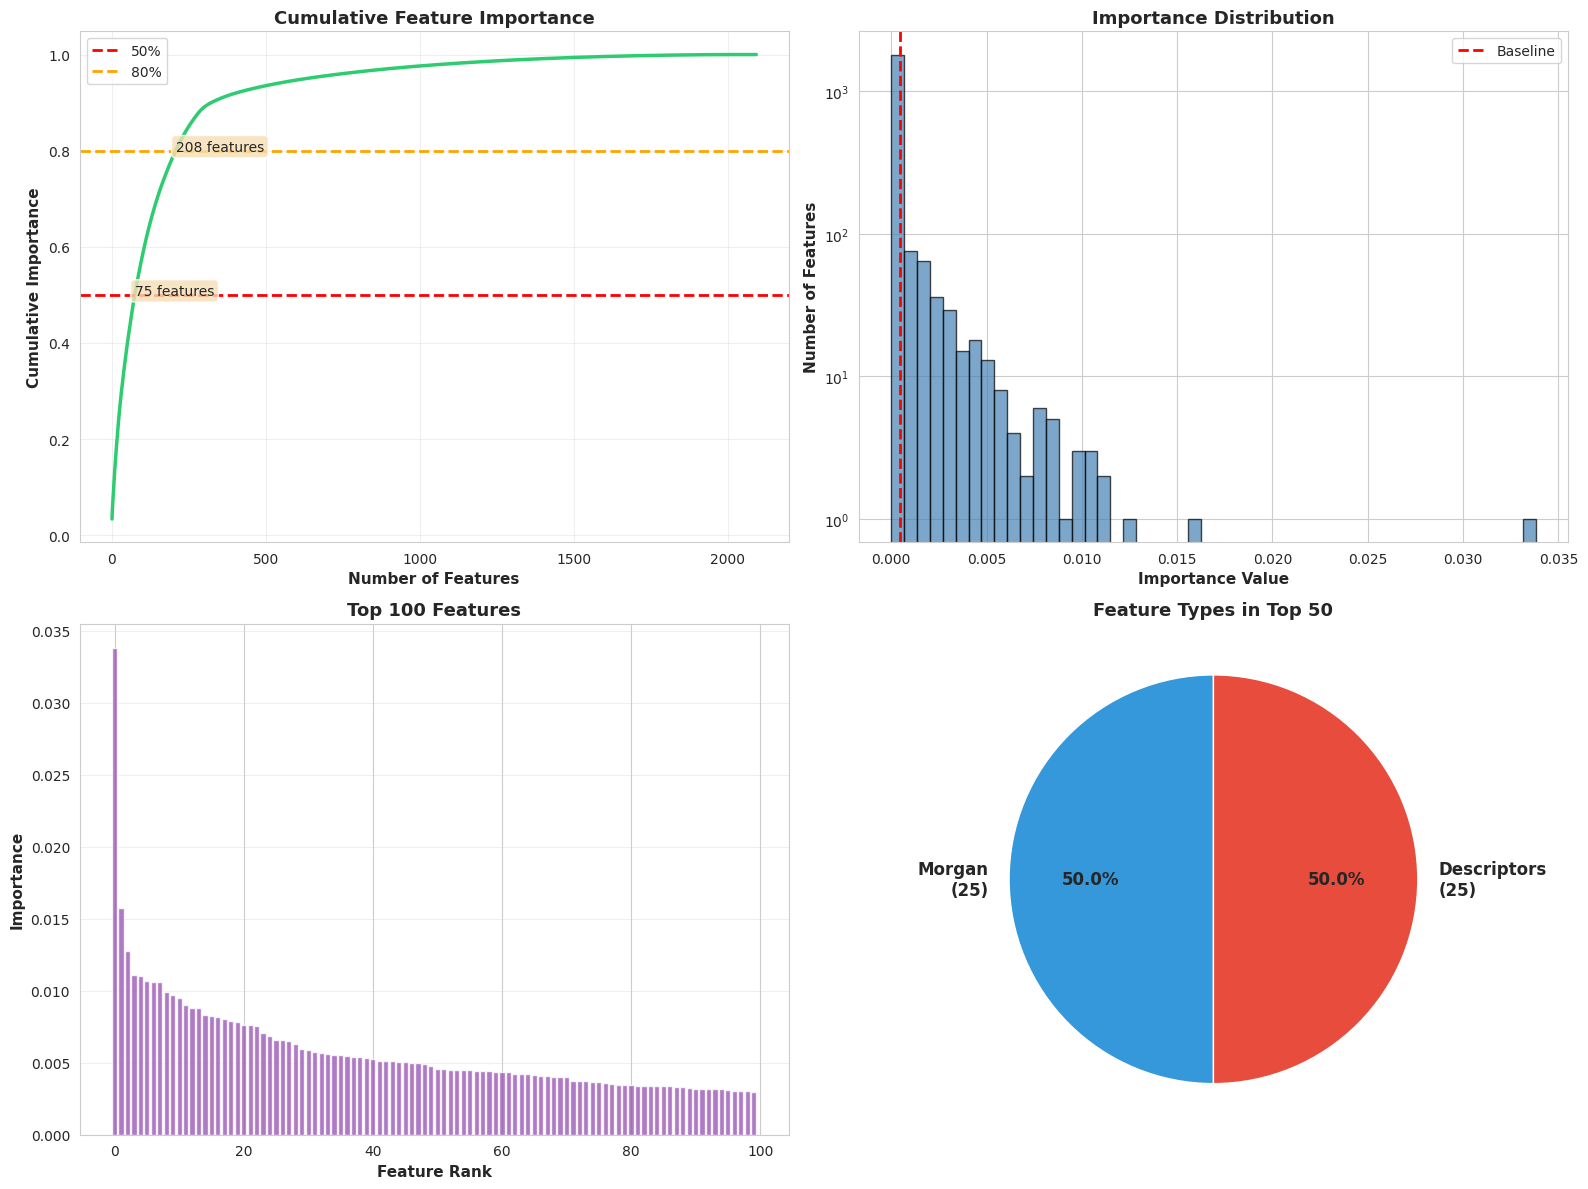

50% captured by: 75 features
80% captured by: 208 features
Effective features: 302 (14.4%)
Significant features: 252 (12.0%)

Max importance: 3.38%
Baseline: 0.0478%
Max/Baseline ratio: 70.7x


In [35]:
n_features = len(feature_cols)
baseline_importance = 1.0 / n_features
max_importance = np.max(ensemble_importance)
top_10_cumulative = np.sum(sorted(ensemble_importance, reverse=True)[:10])
top_50_cumulative = np.sum(sorted(ensemble_importance, reverse=True)[:50])

print(f"Total features: {n_features}")
print(f"Max importance: {max_importance:.4f} ({max_importance*100:.2f}%)")
print(f"Top 10 cumulative: {top_10_cumulative:.4f} ({top_10_cumulative*100:.2f}%)")
print(f"Top 50 cumulative: {top_50_cumulative:.4f} ({top_50_cumulative*100:.2f}%)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sorted_importance = np.sort(ensemble_importance)[::-1]
cumulative_importance = np.cumsum(sorted_importance)

axes[0, 0].plot(range(1, len(cumulative_importance)+1), cumulative_importance, linewidth=2.5, color='#2ecc71')
axes[0, 0].axhline(0.5, color='red', linestyle='--', linewidth=2, label='50%')
axes[0, 0].axhline(0.8, color='orange', linestyle='--', linewidth=2, label='80%')
axes[0, 0].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

n_for_50 = np.argmax(cumulative_importance >= 0.5) + 1
n_for_80 = np.argmax(cumulative_importance >= 0.8) + 1
axes[0, 0].text(n_for_50, 0.5, f'{n_for_50} features', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[0, 0].text(n_for_80, 0.8, f'{n_for_80} features', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

axes[0, 1].hist(ensemble_importance, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(baseline_importance, color='red', linestyle='--', linewidth=2, label=f'Baseline')
axes[0, 1].set_xlabel('Importance Value', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Features', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Importance Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')

top_100 = sorted_importance[:100]
axes[1, 0].bar(range(100), top_100, color='#9b59b6', alpha=0.8)
axes[1, 0].set_xlabel('Feature Rank', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Importance', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 100 Features', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

top_50_features = [feature_cols[i] for i in np.argsort(ensemble_importance)[-50:][::-1]]
n_morgan = len([f for f in top_50_features if f.startswith('MORGAN')])
n_descriptors = len([f for f in top_50_features if not f.startswith('MORGAN')])

axes[1, 1].pie([n_morgan, n_descriptors], labels=[f'Morgan\n({n_morgan})', f'Descriptors\n({n_descriptors})'], 
               autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1, 1].set_title('Feature Types in Top 50', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('importance_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"50% captured by: {n_for_50} features")
print(f"80% captured by: {n_for_80} features")

effective_features = np.sum(ensemble_importance > baseline_importance)
significant_features = np.sum(ensemble_importance > 0.001)

print(f"Effective features: {effective_features} ({effective_features/n_features*100:.1f}%)")
print(f"Significant features: {significant_features} ({significant_features/n_features*100:.1f}%)")
print(f"\nMax importance: {max_importance*100:.2f}%")
print(f"Baseline: {baseline_importance*100:.4f}%")
print(f"Max/Baseline ratio: {max_importance/baseline_importance:.1f}x")

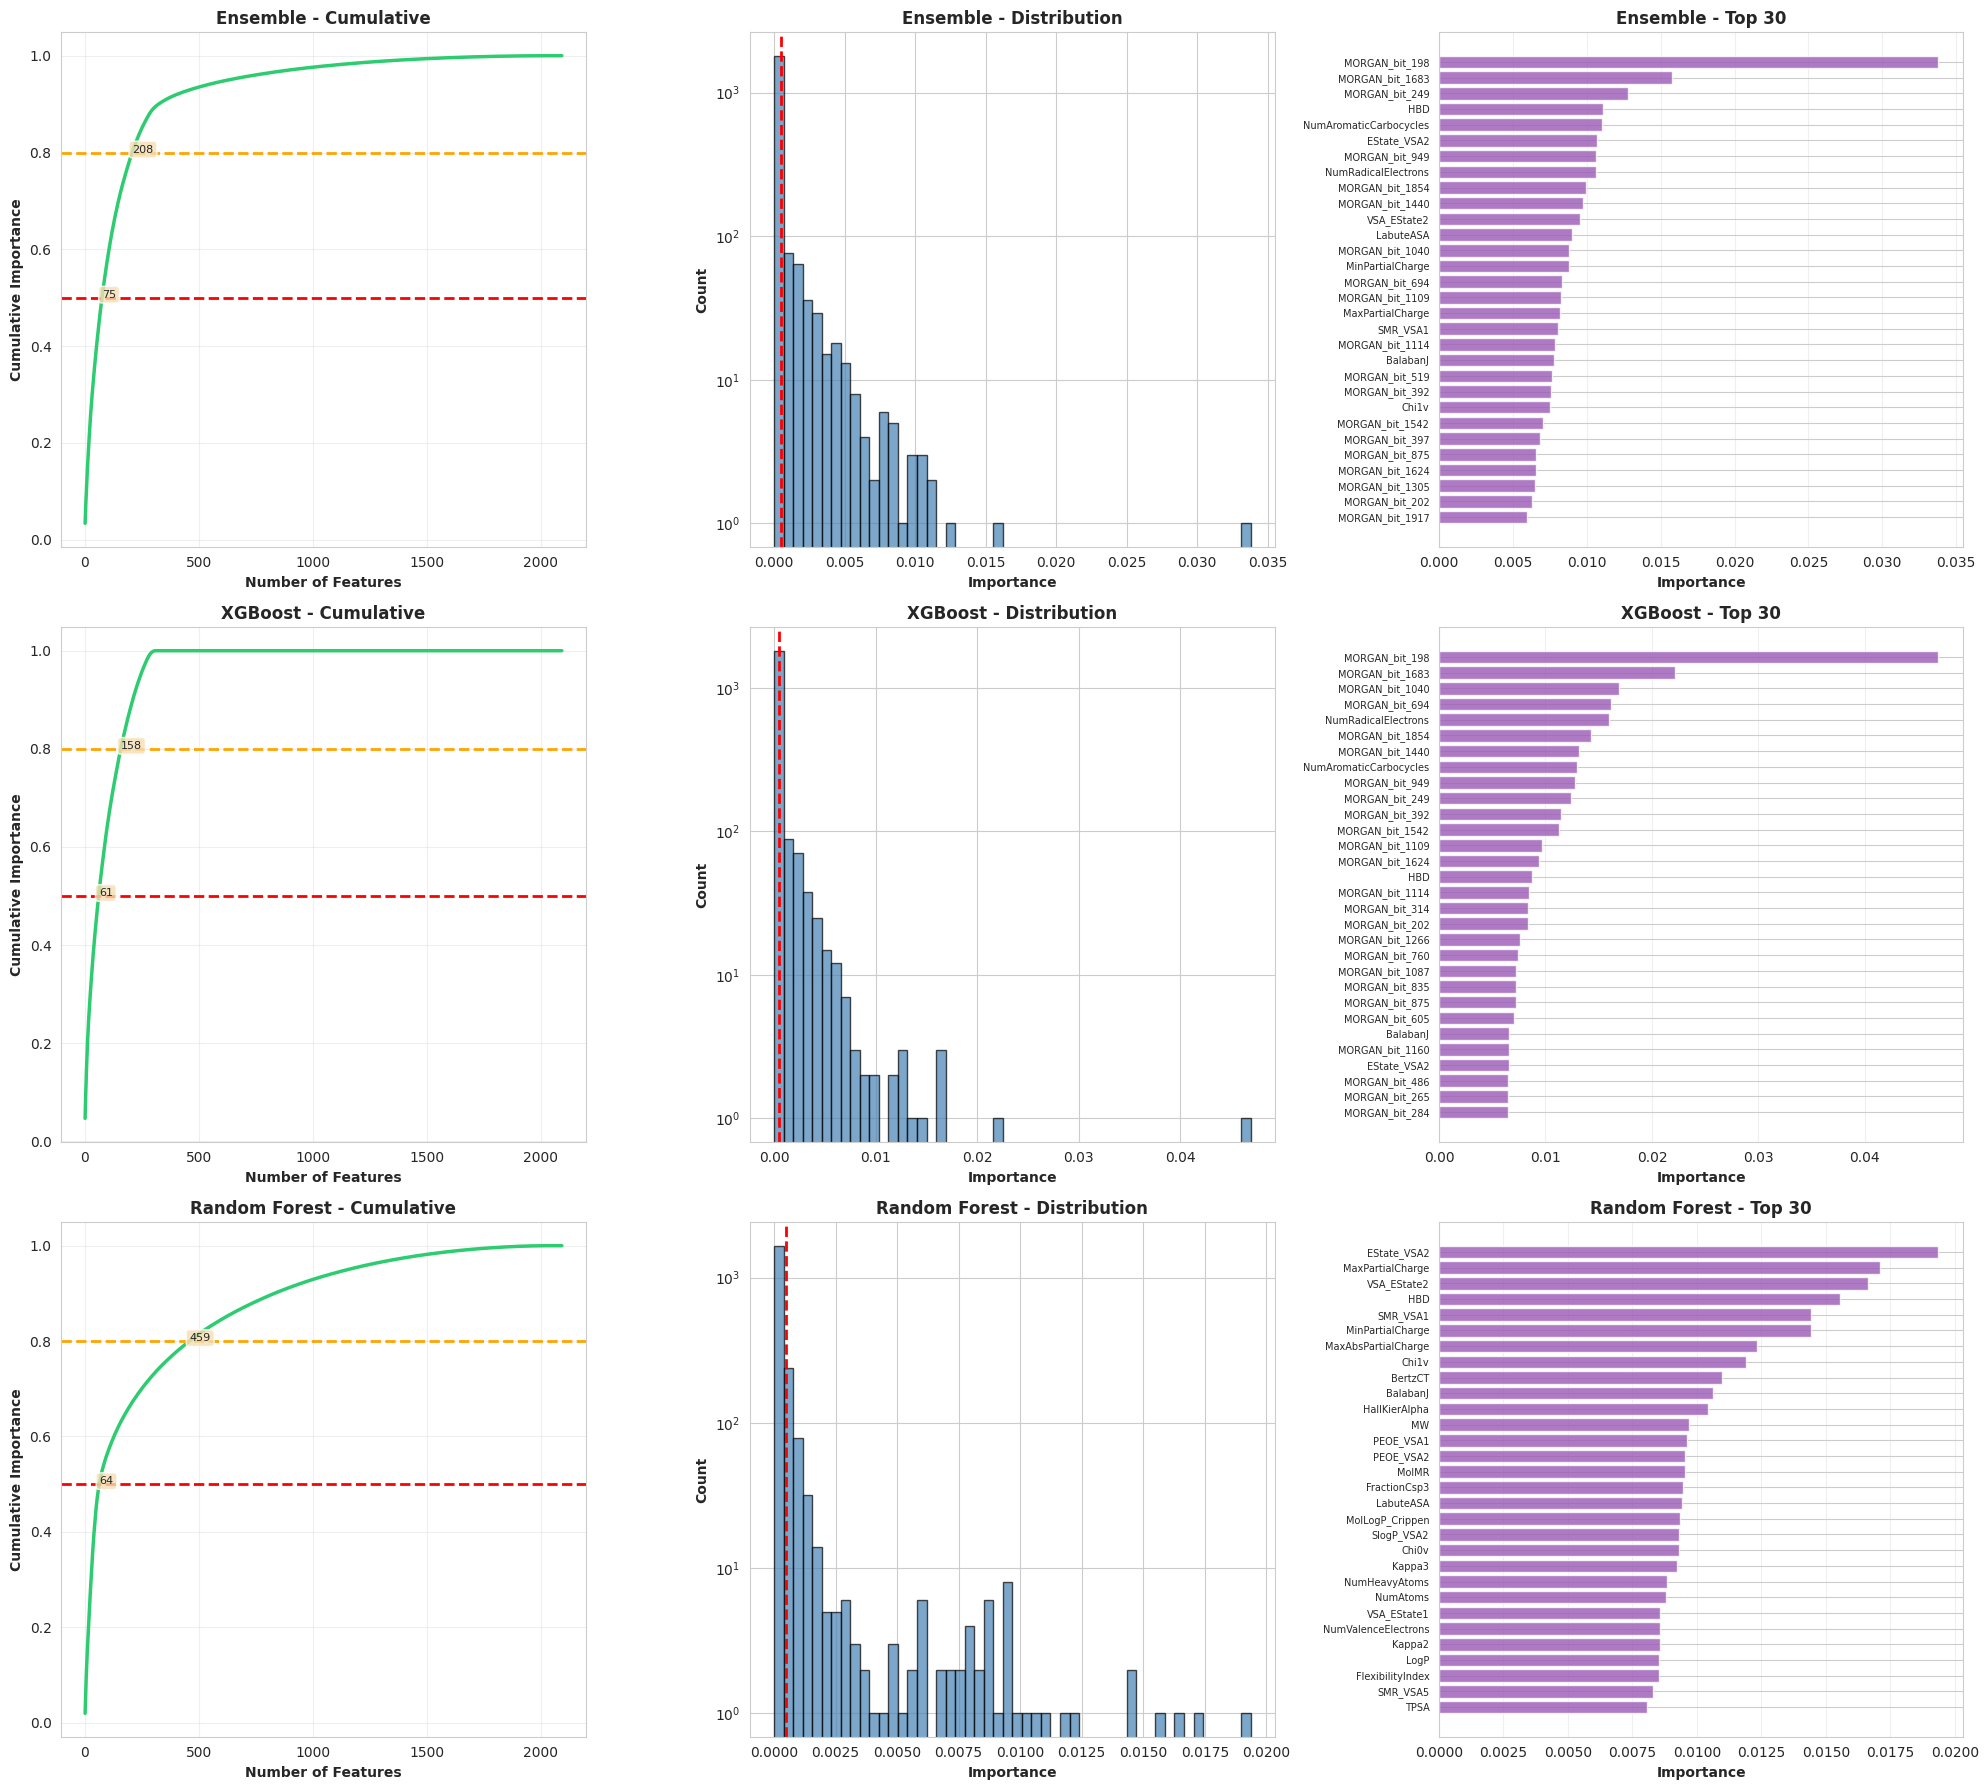

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

for model_idx, (name, importance) in enumerate([
    ('Ensemble', ensemble_importance),
    ('XGBoost', xgb_importance),
    ('Random Forest', rf_importance)
]):
    
    sorted_imp = np.sort(importance)[::-1]
    cumulative_imp = np.cumsum(sorted_imp)
    
    axes[model_idx, 0].plot(range(1, len(cumulative_imp)+1), cumulative_imp, linewidth=2.5, color='#2ecc71')
    axes[model_idx, 0].axhline(0.5, color='red', linestyle='--', linewidth=2)
    axes[model_idx, 0].axhline(0.8, color='orange', linestyle='--', linewidth=2)
    axes[model_idx, 0].set_xlabel('Number of Features', fontsize=10, fontweight='bold')
    axes[model_idx, 0].set_ylabel('Cumulative Importance', fontsize=10, fontweight='bold')
    axes[model_idx, 0].set_title(f'{name} - Cumulative', fontsize=12, fontweight='bold')
    axes[model_idx, 0].grid(alpha=0.3)
    
    n50 = np.argmax(cumulative_imp >= 0.5) + 1
    n80 = np.argmax(cumulative_imp >= 0.8) + 1
    axes[model_idx, 0].text(n50, 0.5, f'{n50}', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[model_idx, 0].text(n80, 0.8, f'{n80}', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[model_idx, 1].hist(importance, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[model_idx, 1].axvline(baseline_importance, color='red', linestyle='--', linewidth=2)
    axes[model_idx, 1].set_xlabel('Importance', fontsize=10, fontweight='bold')
    axes[model_idx, 1].set_ylabel('Count', fontsize=10, fontweight='bold')
    axes[model_idx, 1].set_title(f'{name} - Distribution', fontsize=12, fontweight='bold')
    axes[model_idx, 1].set_yscale('log')
    
    top_30_idx = np.argsort(importance)[-30:]
    axes[model_idx, 2].barh(range(30), importance[top_30_idx], color='#9b59b6', alpha=0.8)
    axes[model_idx, 2].set_yticks(range(30))
    axes[model_idx, 2].set_yticklabels([feature_cols[i] for i in top_30_idx], fontsize=7)
    axes[model_idx, 2].set_xlabel('Importance', fontsize=10, fontweight='bold')
    axes[model_idx, 2].set_title(f'{name} - Top 30', fontsize=12, fontweight='bold')
    axes[model_idx, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('importance_all_3_models_complete.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
import shap

explainer_xgb = shap.TreeExplainer(trained_models['XGBoost'])
shap_values_xgb = explainer_xgb.shap_values(X_test)

explainer_rf = shap.TreeExplainer(trained_models['Random Forest'])
shap_values_rf = explainer_rf.shap_values(X_test)

if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]
elif len(shap_values_rf.shape) == 3:
    shap_values_rf = shap_values_rf[:, :, 1]

shap_values_ensemble = (2 * shap_values_xgb + 1 * shap_values_rf) / 3

print(f"XGBoost SHAP: {shap_values_xgb.shape}")
print(f"RF SHAP: {shap_values_rf.shape}")
print(f"Ensemble SHAP: {shap_values_ensemble.shape}")

XGBoost SHAP: (325, 2092)
RF SHAP: (325, 2092)
Ensemble SHAP: (325, 2092)


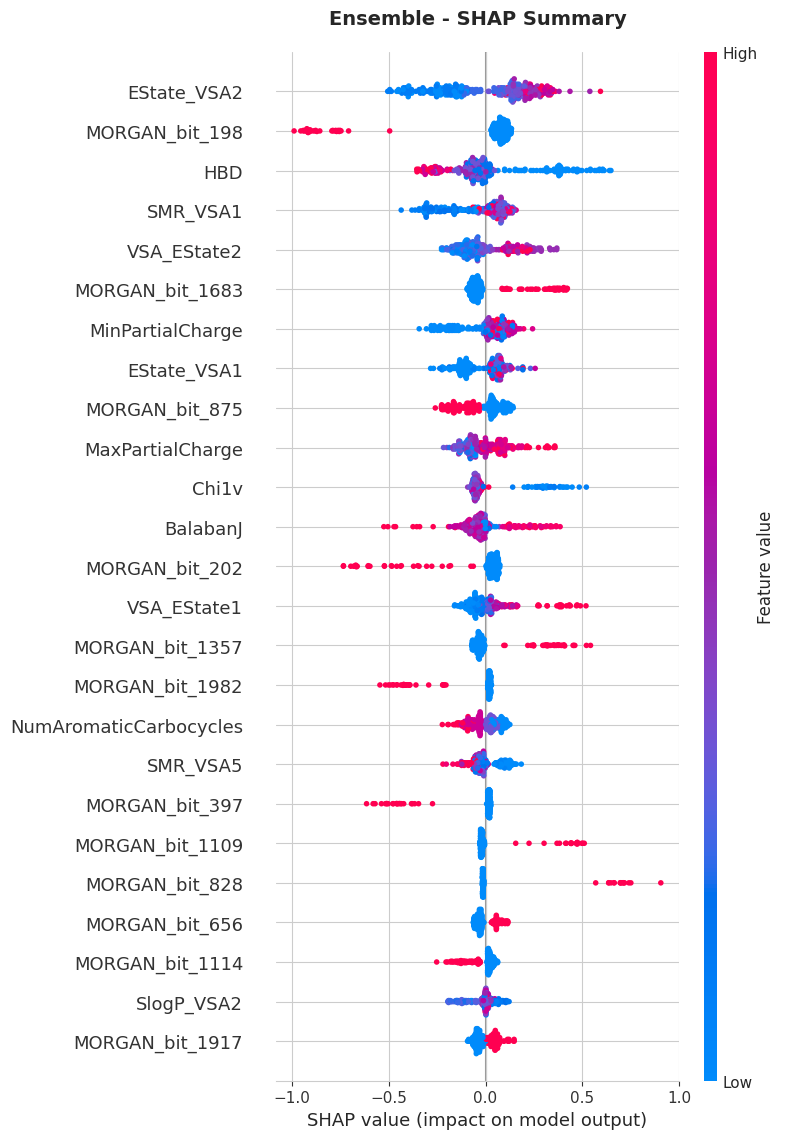

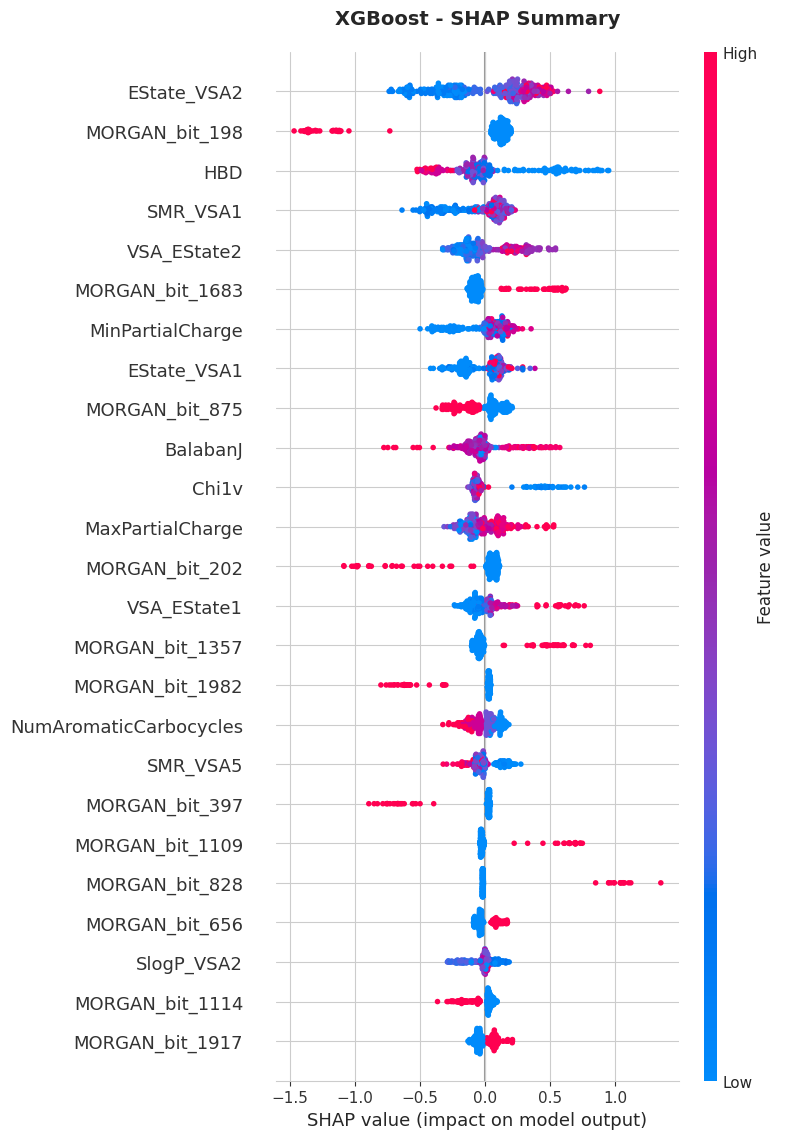

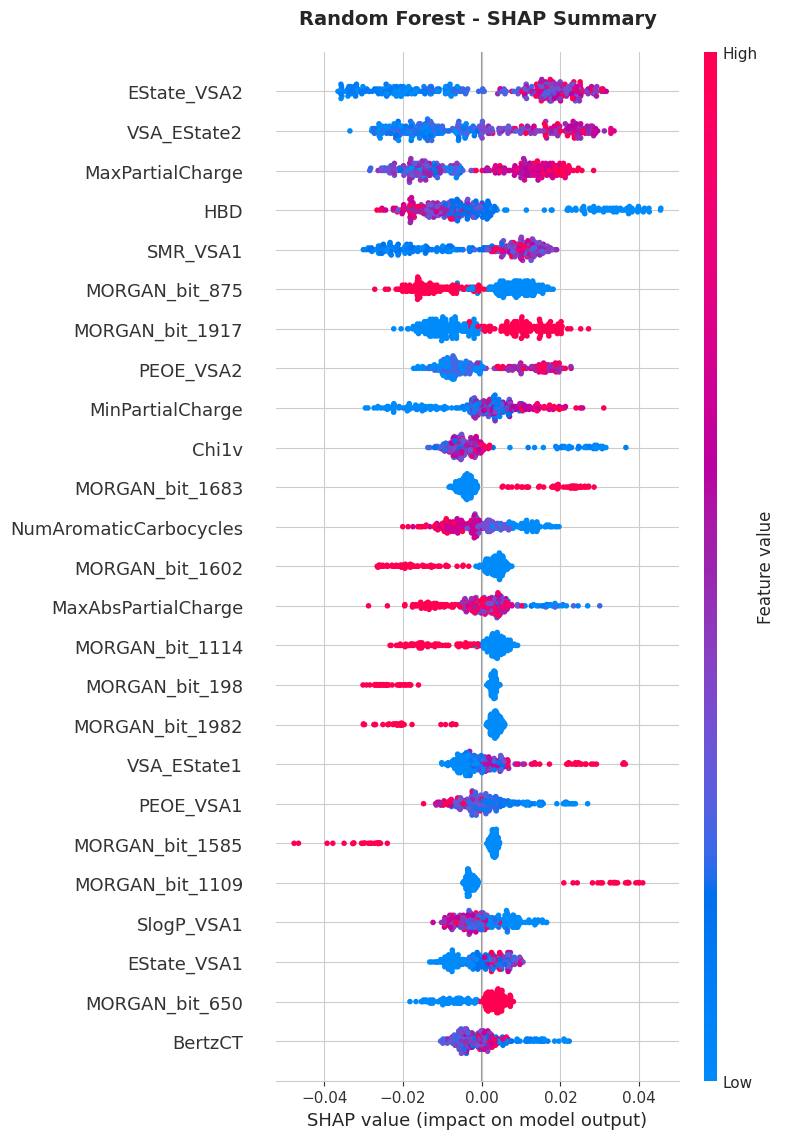

In [38]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_ensemble, X_test, feature_names=feature_cols, max_display=25, show=False)
plt.title('Ensemble - SHAP Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_cols, max_display=25, show=False)
plt.title('XGBoost - SHAP Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X_test, feature_names=feature_cols, max_display=25, show=False)
plt.title('Random Forest - SHAP Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_rf.png', dpi=300, bbox_inches='tight')
plt.show()

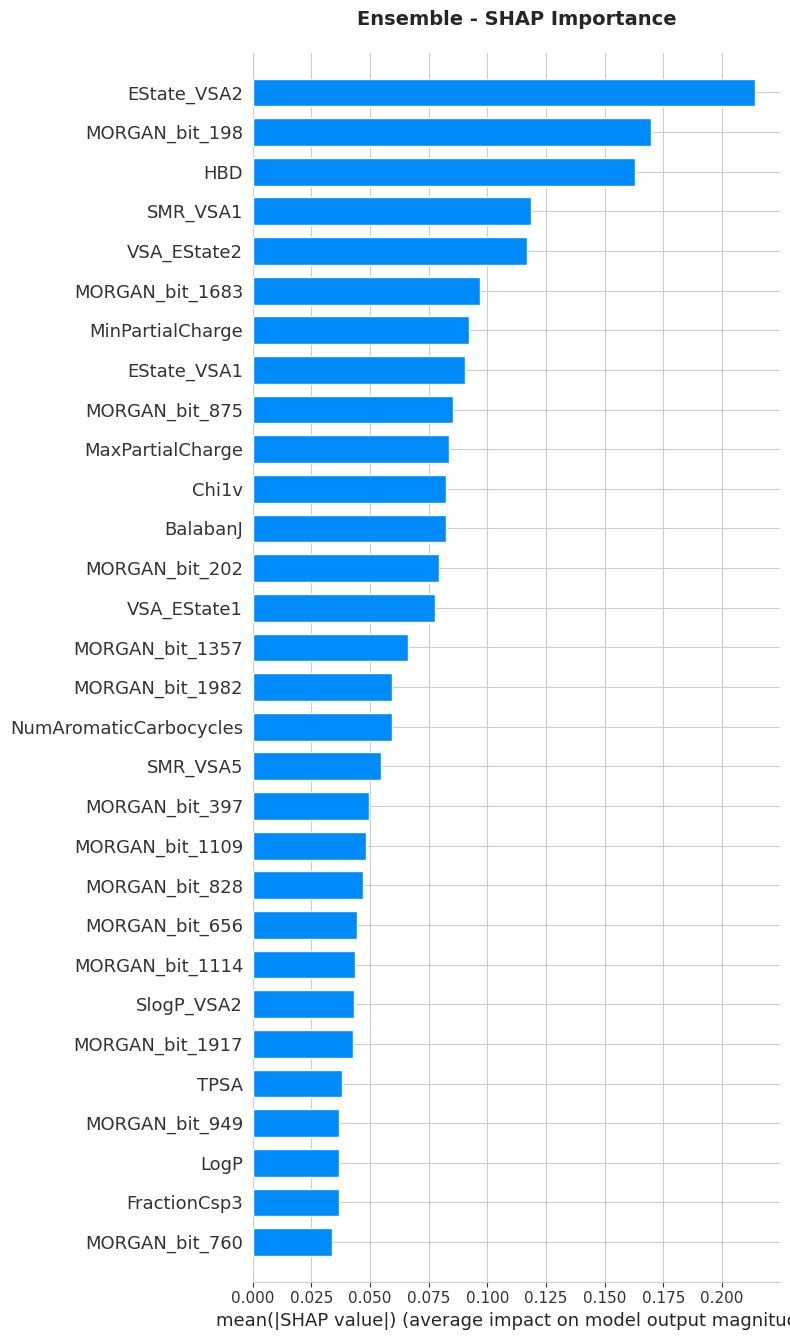

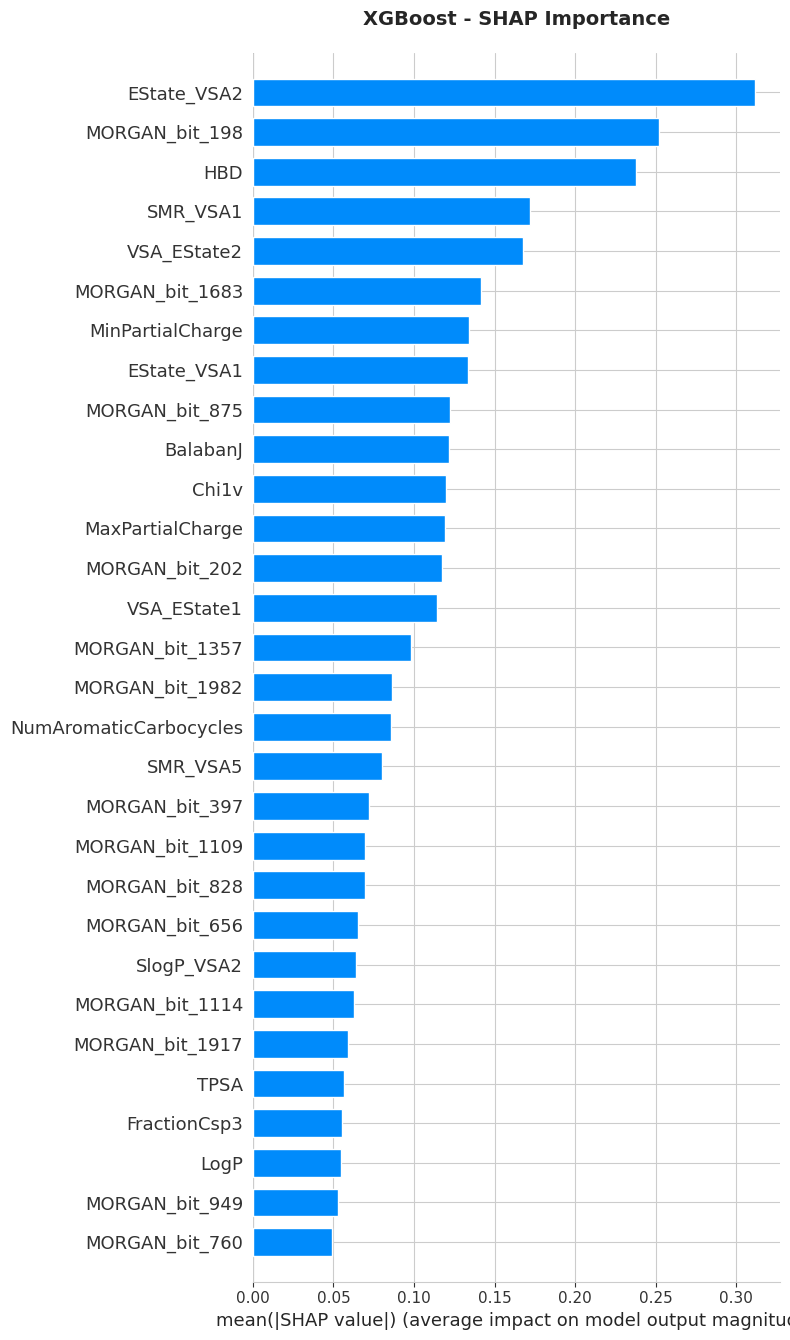

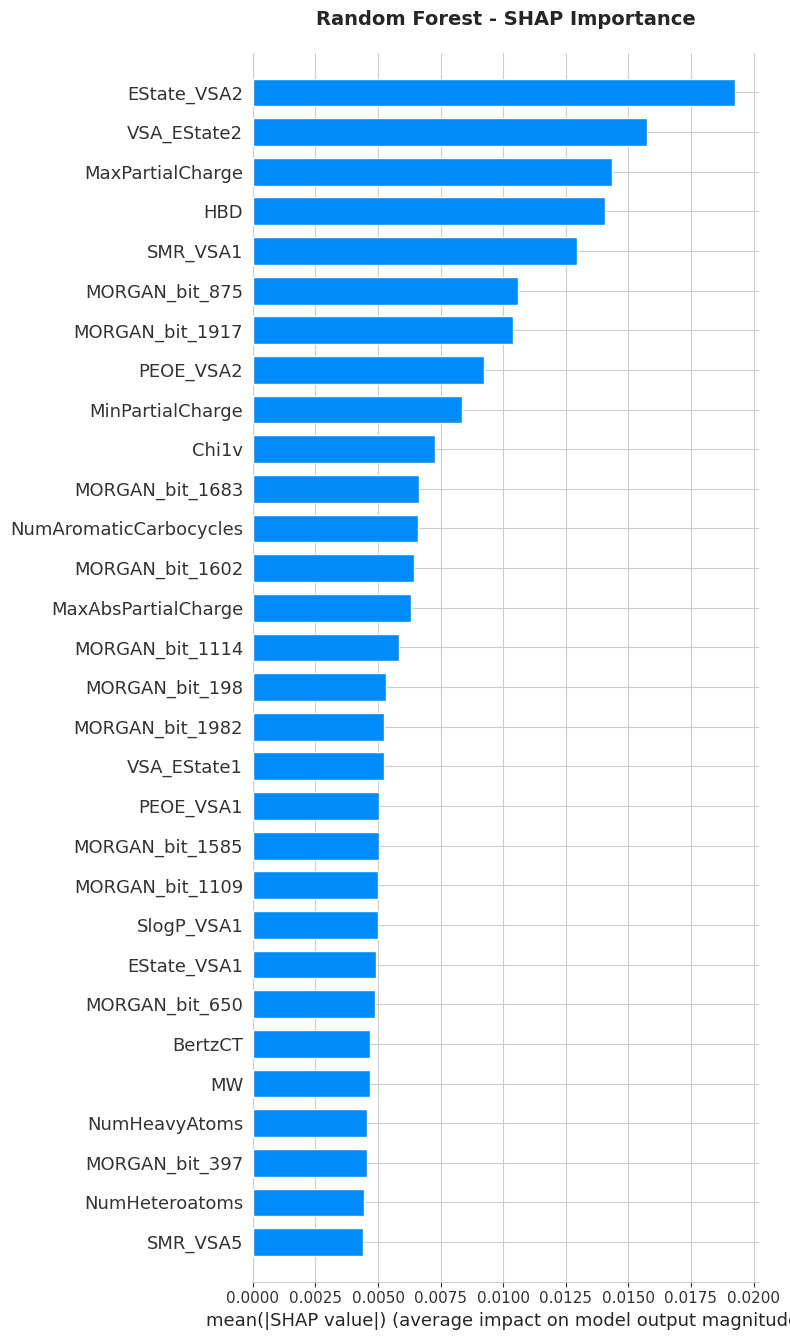

In [39]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_ensemble, X_test, feature_names=feature_cols, plot_type='bar', max_display=30, show=False)
plt.title('Ensemble - SHAP Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_cols, plot_type='bar', max_display=30, show=False)
plt.title('XGBoost - SHAP Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, feature_names=feature_cols, plot_type='bar', max_display=30, show=False)
plt.title('Random Forest - SHAP Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_rf.png', dpi=300, bbox_inches='tight')
plt.show()

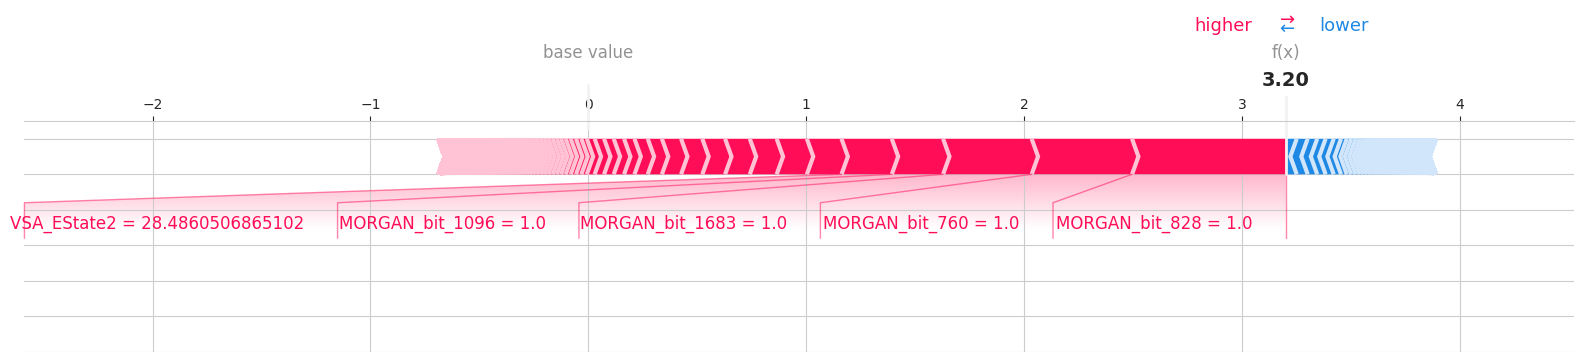

Inducer example: Sample 12, Probability=0.992


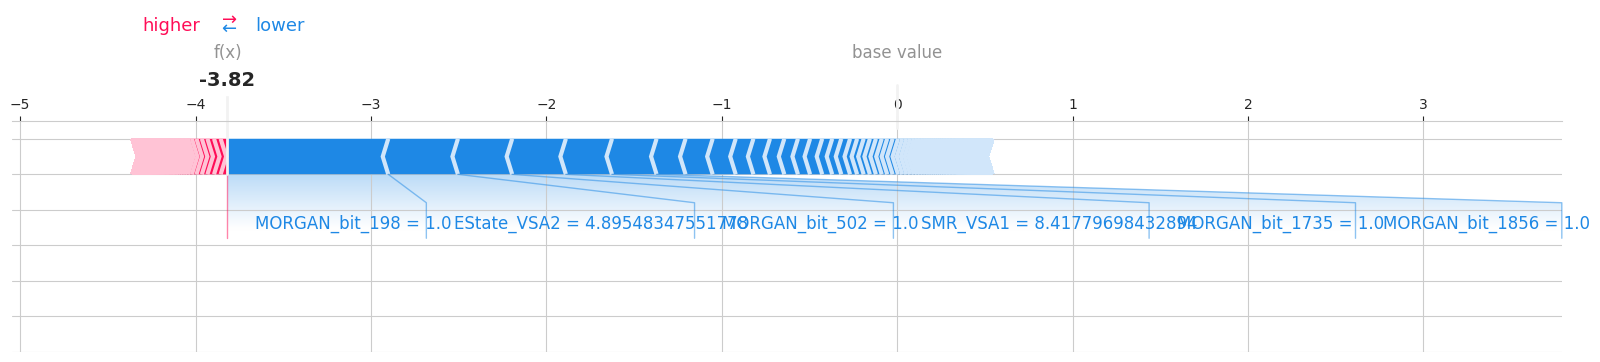

Inhibitor example: Sample 4, Probability=0.992


In [40]:
y_proba_ens = ensemble.predict_proba(X_test)[:, 1]

strong_inducer = np.where((y_test == 1) & (y_proba_ens > 0.95))[0]
strong_inhibitor = np.where((y_test == 0) & (y_proba_ens < 0.05))[0]

if len(strong_inducer) > 0:
    idx = strong_inducer[0]
    shap.force_plot(explainer_xgb.expected_value, shap_values_ensemble[idx], X_test[idx], 
                   feature_names=feature_cols, matplotlib=True, show=False, figsize=(20, 3))
    plt.savefig('shap_force_inducer.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Inducer example: Sample {idx}, Probability={y_proba_ens[idx]:.3f}")

if len(strong_inhibitor) > 0:
    idx = strong_inhibitor[0]
    shap.force_plot(explainer_xgb.expected_value, shap_values_ensemble[idx], X_test[idx], 
                   feature_names=feature_cols, matplotlib=True, show=False, figsize=(20, 3))
    plt.savefig('shap_force_inhibitor.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Inhibitor example: Sample {idx}, Probability={1-y_proba_ens[idx]:.3f}")

In [41]:
np.save('saved_models/shap_values_xgboost.npy', shap_values_xgb)
np.save('saved_models/shap_values_rf.npy', shap_values_rf)
np.save('saved_models/shap_values_ensemble.npy', shap_values_ensemble)
print("All SHAP values saved")

All SHAP values saved
